In [1]:
%matplotlib inline
import functools
import glob
import os

import pandas as pd
import pybedtools
from IPython.core.display import HTML
import numpy as np
import seaborn as sns

from clipper.src import CLIP_analysis
from gscripts.general import dataviz
from gscripts.general import parsers


In [2]:
def eplouge(name,count):
    return """#!/bin/bash
#PBS -N {0}
#PBS -l nodes=1:ppn=1
#PBS -o {0}.out
#PBS -e {0}.err
#PBS -V
#PBS -q home-yeo
#PBS -W group_list=yeo-group
#PBS -t 1-{1}
#PBS -l walltime=8:00:00
cd /home/gpratt/projects/encode/analysis/peak_reanalysis_v12/
echo "hello, starting"
""".format(name, count)

prolouge = "eval ${cmd[$PBS_ARRAYID]}"

In [3]:
def format_clip_analysis(bed_file, bam_file):
    path, ext = os.path.splitext(os.path.basename(bed_file))
    metrics = path + ".metrics"
    return "clip_analysis --clusters {} -s hg19 --bam {} --AS_Structure /projects/ps-yeolab/genomes/hg19/hg19data4 --genome_location /projects/ps-yeolab/genomes/hg19/chromosomes/all.fa --phastcons_location /projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw --nrand 3 --runPhast --metrics {} --gff_db /projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db".format(bed_file, bam_file, metrics)

def l2fc_filter(peak_file, l2fc= 3, p_val= 2):
    bedtool = pybedtools.BedTool(peak_file)

    bedtool = bedtool.filter(lambda interval: (float(interval.score) > l2fc) and (float(interval.name) > p_val))
    bedtool = bedtool.each(move_name)
    bedtool = bedtool.saveas(os.path.join("/home/gpratt/projects/encode/analysis/encode_v9_secondary_processing", 
                                         os.path.basename(peak_file)) + ".filtered.bed")
    return bedtool.fn

def move_name(interval):
    interval.name = interval[7]
    return pybedtools.create_interval_from_list(interval[:6])
    return interval

In [4]:
df = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/KB_v12_20160201/encode_v12_filelist_KB_20160201_nosingle.txt.l2foldenr_files.txt", 
              header=None,
             names=['encode_id', 
                       'rbp', 
                       'cell_type', 
                       'bam_file_1', 
                       'bam_file_2', 
                       'input_file', 
                       'peaks_file_1', 
                       'peaks_file_2'])

In [5]:
df = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/KB_v12_20160201/encode_v12_filelist_KB_20160201_nosingle.txt.l2foldenr_files.txt", 
              header=None,
             names=['encode_id', 
                       'rbp', 
                       'cell_type', 
                       'bam_file_1', 
                       'bam_file_2', 
                       'input_file', 
                       'peaks_file_1', 
                       'peaks_file_2'])

#tidy the data up
result = []
for index, line in df.iterrows():
    result.append({'encode_id': line.encode_id,
                   'rep': 1,
                   'rbp': line.rbp, 
                   'cell_type': line.cell_type, 
                   'bam_file': line.bam_file_1, 
                   'input_file': line.input_file, 
                   'peaks_file': line.peaks_file_1, })
    result.append({'encode_id': line.encode_id,
                       'rep': 2,
                       'rbp': line.rbp, 
                       'cell_type': line.cell_type, 
                       'bam_file': line.bam_file_2, 
                       'input_file': line.input_file, 
                       'peaks_file': line.peaks_file_2, })

df = pd.DataFrame(result)
df['annotated_peaks'] = df.peaks_file.apply(lambda x: x + ".compressed.bed.annotated")

In [6]:
df['filtered_peaks'] = df.annotated_peaks.apply(l2fc_filter)

In [7]:
total = 0 
result = []
for x, row in df.iterrows():
    total += 1
    result.append('cmd[{}]="{}"'.format(total, format_clip_analysis(row.filtered_peaks, row.bam_file)))
    
for name, row in df.groupby("encode_id"):
    print name

    rep1, rep2 = row.filtered_peaks

    rep1 = pybedtools.BedTool(rep1)
    rep2 = pybedtools.BedTool(rep2)

    merged_peaks = rep1.intersect(rep2, s=True, u=True).saveas(os.path.join("/home/gpratt/projects/encode/analysis/encode_v9_secondary_processing", 
                                                                            name + ".merged.compressed.bed.annotated.filtered.bed"))
    print len(rep1), len(rep2), len(merged_peaks)
    result.append('cmd[{}]="{}"'.format(total, format_clip_analysis(merged_peaks.fn, row.bam_file.values[0])))
    
with open(os.path.join("/home/gpratt/projects/encode/scripts", "kb_analysis.sh"), 'w') as out_file:
    out_file.write(eplouge("sebas", total))
    for line in result:
        out_file.write(line + "\n\n")
        

    out_file.write(prolouge + "\n")

KB13-14
38 105 12
KB17-18
365 408 117
KB2-3
50 134 25
KB20-21
1526 1276 320
KB24-25
2990 3800 797
KB27-28
4081 2900 1178
KB4-16
164 283 19
KB6-7
1560 2476 568
KB9-10
1277 651 120


In [8]:
img_dir = "."


BAG2_1 1.18629422753
BAG2_2 0.577581414342
DHX30_1 1.27548212778
DHX30_2 1.4615051665
AIFM1_1 1.12046554764
AIFM1_2 0.637772596818
VIM_1 2.15298508924
VIM_2 1.99522059064
ZNF184_1 1.30294088667
ZNF184_2 1.37671293804
ZNF217_1 1.30144123116
ZNF217_2 1.38450672267
RNF219_1 1.07354735152
RNF219_2 0.759386208185
RANGAP1_1 1.29040554651
RANGAP1_2 1.51165156776


ValueError: num must be 0 <= num <= 8, not 9

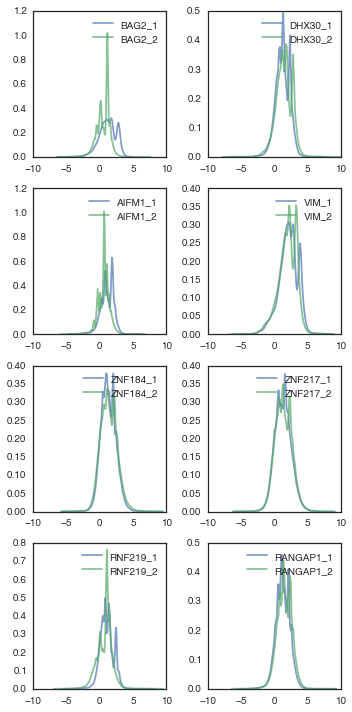

In [9]:
num_rows = 4
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "enrichment.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, (name, rbp_df) in enumerate(df.groupby("encode_id")):
        ax = fig.add_subplot(4,2,x + 1)

        for name, row in rbp_df.iterrows():
            name = row.rbp + "_" + str(row.rep)
            bedtool = pybedtools.BedTool(row.annotated_peaks)
            scores = np.array([float(interval.score) for interval in bedtool])
            print name, scores.mean()

            sns.kdeplot(scores, label=name, ax=ax, alpha=.7)
        ax.legend()
        ax.set_xlim(-10, 10)


Kris’ peaks are under enriched relative to encode in general, interestingly VIM is the only one that displies some enrichment

In [ ]:
encode = glob.glob("/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/*.bed.annotated")

In [ ]:
encode_series = {}
for item in encode:
    name = os.path.basename(item).split(".")[0]
    encode_series[tuple(name.split("_"))] = item
    
encode_series = pd.Series(encode_series)
encode_series.index.names = ['uid', 'rep']

In [ ]:
num_rows = (len(list(encode_series.groupby(level="uid"))) / 2) + 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "enrichment.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, (name, rbp_df) in enumerate(encode_series.groupby(level="uid")):
        for name, row in rbp_df.iteritems():
            name = "_".join(name)
            bedtool = pybedtools.BedTool(row)
            scores = np.array([float(interval.score) for interval in bedtool])
            print name, scores.mean()


In [ ]:
num_rows = (len(list(encode_series.groupby(level="uid"))) / 2) + 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "enrichment.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, (name, rbp_df) in enumerate(encode_series.groupby(level="uid")):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)

        for name, row in rbp_df.iteritems():
            name = "_".join(name)
            bedtool = pybedtools.BedTool(row)
            scores = np.array([float(interval.score) for interval in bedtool])
            
            sns.kdeplot(scores, label=name, ax=ax, alpha=.7)
            ax.set_xlim(-10, 10)
        ax.legend()